### File Upload

In [ ]:
from google.colab import files

try:
  uploaded = files.upload()
except Exception as e:
  print(f"An error occurred during file upload: {e}")
  uploaded = None

if uploaded is not None:
  for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
else:
  print("File upload was cancelled or failed.")

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv
User uploaded file "Fake.csv" with length 62789876 bytes
User uploaded file "True.csv" with length 53582940 bytes


### Load and Combine Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# Load datasets
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# Add labels
df_fake['label'] = 0  # 0 for Fake
df_true['label'] = 1  # 1 for Real

# Combine
df = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

# Inspect data
print(df.head())
print(df['label'].value_counts())


                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  
label
0    23481
1    21417
Name: count, dtype: in

### Exploratory Data Analysis (EDA) - Distributions

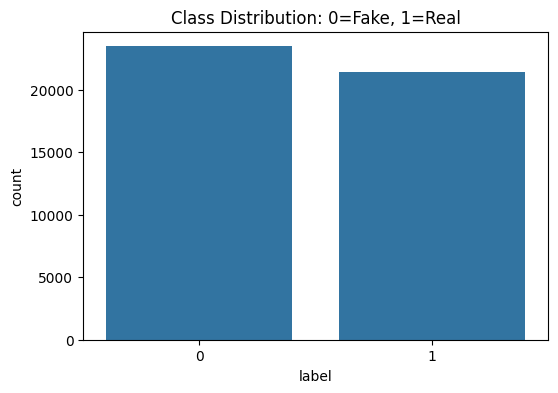

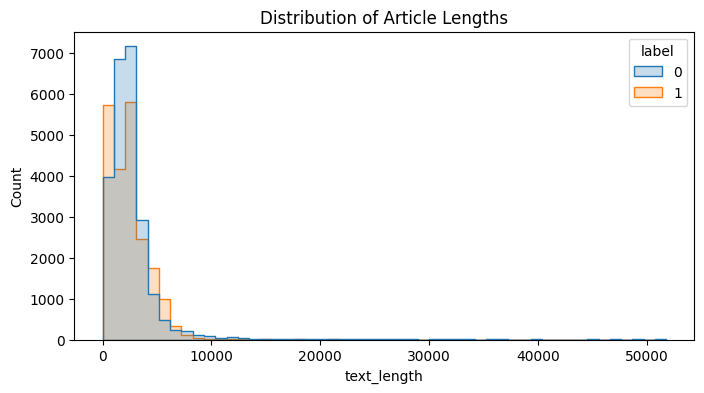

In [ ]:
# Save class distribution plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Class Distribution: 0=Fake, 1=Real')
plt.savefig('class_distribution.png')
plt.show()

# Add article length column for EDA
df['text_length'] = df['text'].astype(str).apply(len)

# Histogram of text lengths
plt.figure(figsize=(8,4))
sns.histplot(df, x='text_length', hue='label', bins=50, element="step")
plt.title('Distribution of Article Lengths')
plt.savefig('article_length_hist.png')
plt.show()

### EDA - Word Clouds and Baseline Accuracy

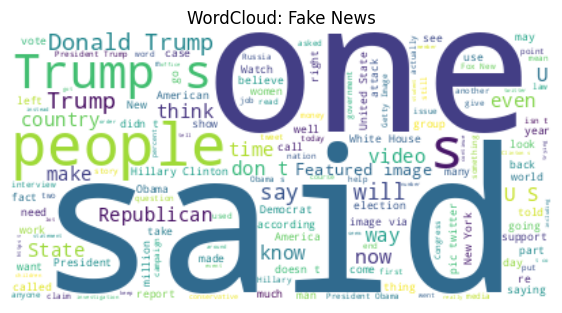

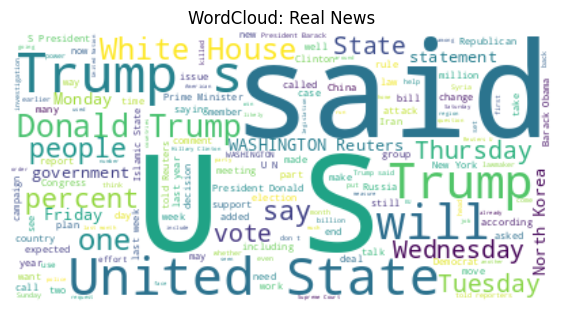

Baseline (majority class) accuracy: 0.523


In [ ]:
def plot_wordcloud(text, title, filename):
    wc = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=150).generate(' '.join(text))
    plt.figure(figsize=(7,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(filename)
    plt.show()

# WordCloud for Fake News
plot_wordcloud(df[df['label'] == 0]['text'], 'WordCloud: Fake News', 'wordcloud_fake.png')

# WordCloud for Real News
plot_wordcloud(df[df['label'] == 1]['text'], 'WordCloud: Real News', 'wordcloud_real.png')

# Baseline majority class accuracy
majority_class = df['label'].value_counts().idxmax()
baseline_acc = (df['label'] == majority_class).mean()
print(f"Baseline (majority class) accuracy: {baseline_acc:.3f}")

### Traditional Models (Naive Bayes and SVM)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0      0.936     0.943     0.939      4696
           1      0.936     0.929     0.933      4284

    accuracy                          0.936      8980
   macro avg      0.936     0.936     0.936      8980
weighted avg      0.936     0.936     0.936      8980

Naive Bayes ROC AUC: 0.9799943969637827

Linear SVM Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.993     0.994      4696
           1      0.992     0.994     0.993      4284

    accuracy                          0.994      8980
   macro avg      0.993     0.994     0.994      8980
weighted avg      0.994     0.994     0.994      8980

Linear SVM ROC-AUC: 0.9995224594664669
[SVM] C=0.5 AUC=0.999
[SVM] C=1.0 AUC=1.000
[SVM] C=2.0 AUC=1.000


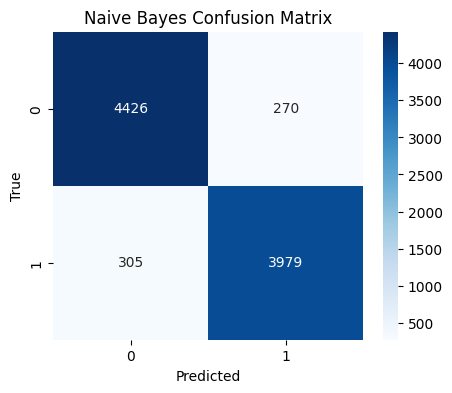

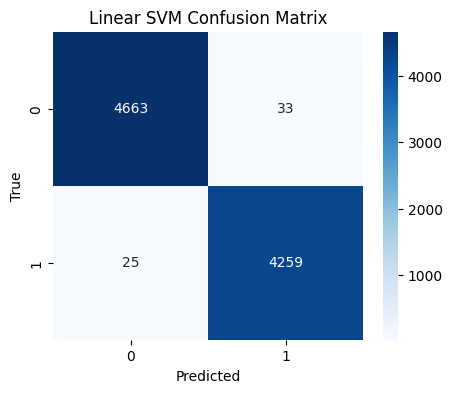

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:,1]

# Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)


# Metrics
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, digits=3))
print("Naive Bayes ROC AUC:", roc_auc_score(y_test, y_proba_nb))

print("\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, digits=3))
# SVM ROC-AUC (using decision_function scores)
y_score_svm = svm.decision_function(X_test_tfidf)
print("Linear SVM ROC-AUC:", roc_auc_score(y_test, y_score_svm))

# SVM micro-tuning
for C in [0.5, 1.0, 2.0]:
    svm_t = LinearSVC(C=C)
    svm_t.fit(X_train_tfidf, y_train)
    y_score_t = svm_t.decision_function(X_test_tfidf)
    print(f"[SVM] C={C} AUC={roc_auc_score(y_test, y_score_t):.3f}")


# Confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

def plot_conf_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.savefig(filename)
    plt.show()

plot_conf_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix", "nb_conf_matrix.png")
plot_conf_matrix(y_test, y_pred_svm, "Linear SVM Confusion Matrix", "svm_conf_matrix.png")

### Temporal split

In [ ]:
import re, numpy as np, pandas as pd
from dateutil import parser as dateparser

def _clean_date_str(s):
    if pd.isna(s): return None
    s = str(s).strip()
    # remove zero-width / bidi controls
    s = re.sub(r'[\u200b\u200e\u202a-\u202e]', '', s)
    # normalise common variants
    s = s.replace('Sept.', 'Sep').replace('Sept', 'Sep')
    s = s.replace('UTC', '').replace('GMT', '').replace('Z', '')
    s = s.replace('T', ' ')  # 2017-01-01T00:00:00 -> 2017-01-01 00:00:00
    return s

def parse_date_safe(s):
    s = _clean_date_str(s)
    if not s: return pd.NaT
    for fmt in ('%B %d, %Y', '%b %d, %Y', '%Y-%m-%d %H:%M:%S', '%Y-%m-%d'):
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            pass
    # Fallback
    try:
        return pd.to_datetime(s, infer_datetime_format=True, errors='raise')
    except Exception:
        try:
            return pd.Timestamp(dateparser.parse(s, fuzzy=True))
        except Exception:
            return pd.NaT

df['date_parsed'] = df['date'].apply(parse_date_safe)

print("Parsed-date availability per label (fraction with a valid date):")
print(df.groupby('label')['date_parsed'].apply(lambda x: x.notna().mean()).round(3))
print("\nExample rows with parsed dates:")
print(df[['date','date_parsed','label']].head(8))


/tmp/ipython-input-2593879548.py:26: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, infer_datetime_format=True, errors='raise')


Parsed-date availability per label (fraction with a valid date):
label
0    0.981
1    0.899
Name: date_parsed, dtype: float64

Example rows with parsed dates:
                  date date_parsed  label
0    February 13, 2017  2017-02-13      0
1       April 5, 2017   2017-04-05      1
2  September 27, 2017          NaT      1
3         May 22, 2017  2017-05-22      0
4       June 24, 2016   2016-06-24      1
5        June 22, 2016  2016-06-22      0
6         Feb 19, 2017  2017-02-19      0
7          Mar 8, 2016  2016-03-08      0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

def _pos_proba(estimator, X):
    """Return P(y=1) safely for models with predict_proba, zeros if class 1 absent."""
    proba = estimator.predict_proba(X)
    classes = list(getattr(estimator, "classes_", []))
    if 1 in classes:
        return proba[:, classes.index(1)]
    return np.zeros(X.shape[0], dtype=float)

def _both_classes(y):
    return np.unique(y).size == 2

def temporal_eval_safe(df, date_col='date_parsed', q=0.80, max_features=10000, try_adjust=True):
    dfx = df.dropna(subset=[date_col, 'text', 'label']).copy()
    if dfx.empty:
        print("[Temporal] No rows with parsed dates.")
        return None

    def _run_at(cut):
        tr = dfx[dfx[date_col] <= cut]
        te = dfx[dfx[date_col] >  cut]
        print(f"[Temporal] cutoff={cut} | train={len(tr)} | test={len(te)}")
        print("  Train label counts:", tr['label'].value_counts().to_dict())
        print("  Test  label counts:", te['label'].value_counts().to_dict())

        vect = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=(1,2))
        Xtr = vect.fit_transform(tr['text']); ytr = tr['label'].values
        Xte = vect.transform(te['text']); yte = te['label'].values

        nb_auc = svm_auc = None
        if _both_classes(ytr) and _both_classes(yte):
            nb = MultinomialNB(alpha=0.5).fit(Xtr, ytr)
            nb_auc = roc_auc_score(yte, _pos_proba(nb, Xte))

            svm = LinearSVC(C=1.0).fit(Xtr, ytr)
            svm_auc = roc_auc_score(yte, svm.decision_function(Xte))

        print(f"  AUCs -> NB: {nb_auc} | SVM: {svm_auc}")
        return nb_auc, svm_auc

    cut = dfx[date_col].quantile(q)
    nb_auc, svm_auc = _run_at(cut)

    if try_adjust and (nb_auc is None or svm_auc is None):

        for q2 in (0.75, 0.70, 0.85, 0.65, 0.90, 0.60, 0.95):
            cut2 = dfx[date_col].quantile(q2)
            nb_auc, svm_auc = _run_at(cut2)
            if nb_auc is not None and svm_auc is not None:
                break

    return {'nb_auc': nb_auc, 'svm_auc': svm_auc}

# Reuse i.i.d.
auc_nb_iid  = roc_auc_score(y_test, y_proba_nb)
auc_svm_iid = roc_auc_score(y_test, y_score_svm)

temporal = temporal_eval_safe(df)

if temporal and temporal['nb_auc'] is not None and temporal['svm_auc'] is not None:
    drop_nb  = max(0.0, (auc_nb_iid  - temporal['nb_auc'])  / auc_nb_iid  * 100)
    drop_svm = max(0.0, (auc_svm_iid - temporal['svm_auc']) / auc_svm_iid * 100)
    print(f"[Temporal] Δ% drop NB: {drop_nb:.2f}% | SVM: {drop_svm:.2f}%")

else:
    print("\n[Temporal] No temporal split available.")


[Temporal] cutoff=2017-10-19 00:00:00 | train=33981 | test=8307
  Train label counts: {0: 21774, 1: 12207}
  Test  label counts: {1: 7044, 0: 1263}
  AUCs -> NB: 0.9881272247333017 | SVM: 0.9998532018849509
[Temporal] Δ% drop NB: 0.00% | SVM: 0.00%


### Text Tokenization and Padding (for Deep Learning Models)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 400  # Pad/truncate to 400 words per article

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


### Build and Compile LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Model
model_lstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train LSTM Model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/5
253/253 - 18s - 70ms/step - accuracy: 0.9794 - loss: 0.0644 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 2/5
253/253 - 15s - 60ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9997 - val_loss: 3.9154e-04
Epoch 3/5
253/253 - 10s - 40ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 9.7017e-04
Epoch 4/5
253/253 - 10s - 40ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 2.3171e-05
Epoch 5/5
253/253 - 9s - 37ms/step - accuracy: 1.0000 - loss: 4.4927e-04 - val_accuracy: 0.9997 - val_loss: 3.0408e-04


### Evaluate LSTM Model

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0      0.998     1.000     0.999      4696
           1      1.000     0.998     0.999      4284

    accuracy                          0.999      8980
   macro avg      0.999     0.999     0.999      8980
weighted avg      0.999     0.999     0.999      8980

LSTM ROC-AUC: 0.9999558099787331


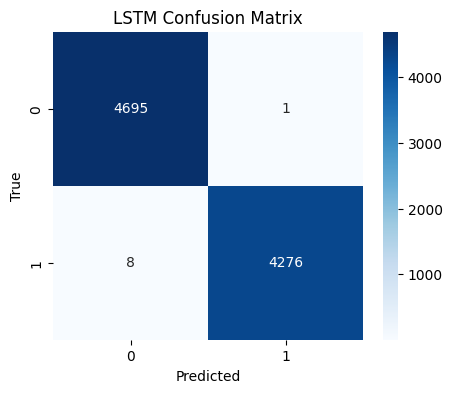

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict
y_pred_prob = model_lstm.predict(X_test_pad).flatten()
y_pred_lstm = (y_pred_prob > 0.5).astype(int)

print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, digits=3))
print("LSTM ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
plot_conf_matrix(y_test, y_pred_lstm, "LSTM Confusion Matrix", "lstm_conf_matrix.png")


### Build and Compile CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train CNN Model

In [ ]:
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=2
)


Epoch 1/5
253/253 - 12s - 46ms/step - accuracy: 0.9629 - loss: 0.1005 - val_accuracy: 0.9983 - val_loss: 0.0042
Epoch 2/5
253/253 - 3s - 13ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.9983 - val_loss: 0.0046
Epoch 3/5
253/253 - 5s - 21ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9997 - val_loss: 7.6703e-04
Epoch 4/5
253/253 - 3s - 13ms/step - accuracy: 0.9998 - loss: 6.8935e-04 - val_accuracy: 0.9997 - val_loss: 9.9159e-04
Epoch 5/5
253/253 - 3s - 13ms/step - accuracy: 0.9998 - loss: 5.9258e-04 - val_accuracy: 1.0000 - val_loss: 3.5666e-04


### Evaluate CNN Model

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      4696
           1      1.000     0.999     0.999      4284

    accuracy                          0.999      8980
   macro avg      0.999     0.999     0.999      8980
weighted avg      0.999     0.999     0.999      8980

CNN ROC-AUC: 0.99999378655494


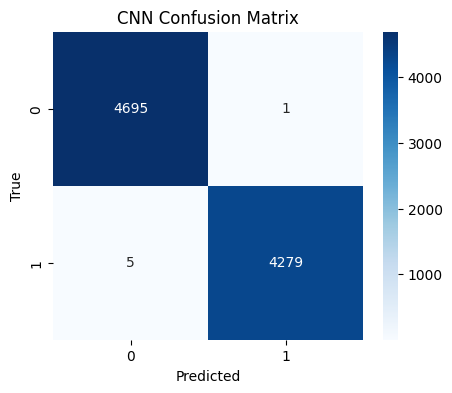

In [ ]:
y_pred_cnn_prob = cnn_model.predict(X_test_pad).flatten()
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int)

print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, digits=3))
print("CNN ROC-AUC:", roc_auc_score(y_test, y_pred_cnn_prob))

plot_conf_matrix(y_test, y_pred_cnn, "CNN Confusion Matrix", "cnn_conf_matrix.png")


### Build and Compile GRU Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

gru_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train GRU Model

In [ ]:
history_gru = gru_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=2
)


Epoch 1/5
253/253 - 13s - 50ms/step - accuracy: 0.9659 - loss: 0.0890 - val_accuracy: 0.9989 - val_loss: 0.0028
Epoch 2/5
253/253 - 9s - 37ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 1.8436e-04
Epoch 3/5
253/253 - 10s - 39ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 2.5402e-04
Epoch 4/5
253/253 - 10s - 41ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 0.0015


### Evaluate GRU Model

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      4696
           1      1.000     0.999     0.999      4284

    accuracy                          0.999      8980
   macro avg      0.999     0.999     0.999      8980
weighted avg      0.999     0.999     0.999      8980

GRU ROC-AUC: 0.9999494971185521


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[Ablation] LSTM units=128 AUC: 0.9998837837235973


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[Ablation] GRU units=128 AUC: 0.9998214504427552


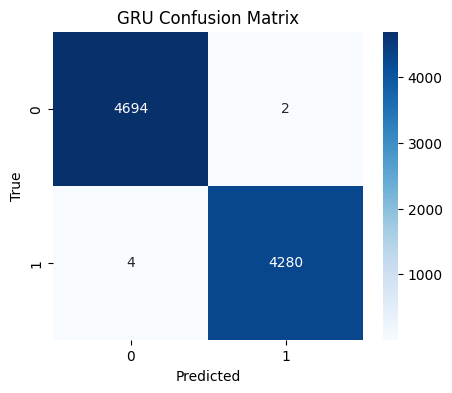

In [ ]:
y_pred_gru_prob = gru_model.predict(X_test_pad).flatten()
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)

print("GRU Classification Report:")
print(classification_report(y_test, y_pred_gru, digits=3))
print("GRU ROC-AUC:", roc_auc_score(y_test, y_pred_gru_prob))
#  Quick ablations
try:
    # LSTM units ablation
    model_lstm_abl = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_lstm_abl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_lstm_abl.fit(X_train_pad, y_train, validation_split=0.1, epochs=1, batch_size=128, verbose=0)
    y_prob_lstm_abl = model_lstm_abl.predict(X_test_pad, verbose=0).flatten()
    print("[Ablation] LSTM units=128 AUC:", roc_auc_score(y_test, y_prob_lstm_abl))

    # GRU units ablation
    gru_model_abl = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(GRU(128, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    gru_model_abl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    gru_model_abl.fit(X_train_pad, y_train, validation_split=0.1, epochs=1, batch_size=128, verbose=0)
    y_prob_gru_abl = gru_model_abl.predict(X_test_pad, verbose=0).flatten()
    print("[Ablation] GRU units=128 AUC:", roc_auc_score(y_test, y_prob_gru_abl))
except Exception as e:
    print("Ablation skipped due to environment limits:", e)


plot_conf_matrix(y_test, y_pred_gru, "GRU Confusion Matrix", "gru_conf_matrix.png")


### Compare Model Performance (ROC Curves)

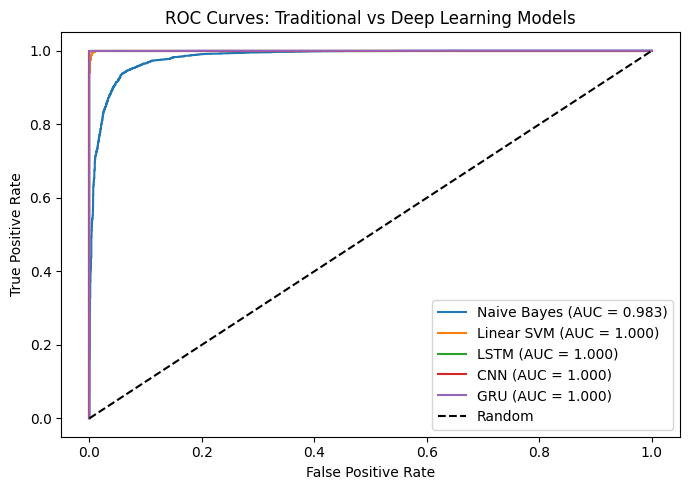

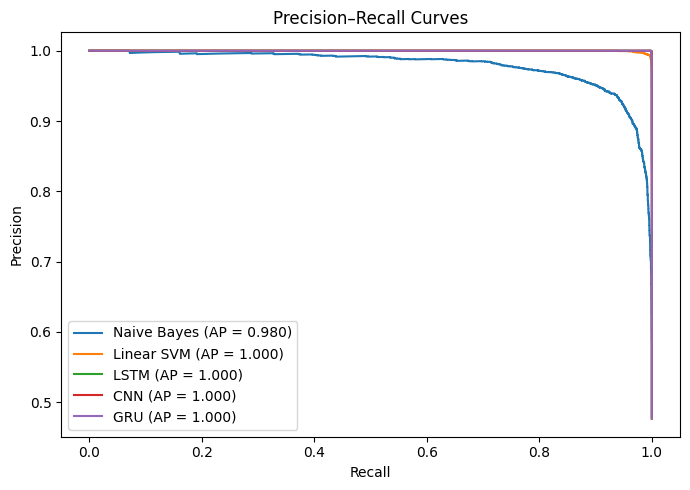

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,5))

# Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = {:.3f})'.format(roc_auc_nb))

# Linear SVM (decision scores)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label='Linear SVM (AUC = {:.3f})'.format(roc_auc_svm))

# LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (AUC = {:.3f})'.format(roc_auc_lstm))

# CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, label='CNN (AUC = {:.3f})'.format(roc_auc_cnn))

# GRU
fpr_gru, tpr_gru, _ = roc_curve(y_test, y_pred_gru_prob)
roc_auc_gru = auc(fpr_gru, tpr_gru)
plt.plot(fpr_gru, tpr_gru, label='GRU (AUC = {:.3f})'.format(roc_auc_gru))

# Baseline diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Traditional vs Deep Learning Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_comparison.png')
plt.show()
# Precision-Recall Curves
plt.figure(figsize=(7,5))
# NB
p_nb, r_nb, _ = precision_recall_curve(y_test, y_proba_nb)
ap_nb = average_precision_score(y_test, y_proba_nb)
plt.plot(r_nb, p_nb, label=f'Naive Bayes (AP = {ap_nb:.3f})')
# SVM (decision scores converted via ranking)
p_svm, r_svm, _ = precision_recall_curve(y_test, y_score_svm)
ap_svm = average_precision_score(y_test, y_score_svm)
plt.plot(r_svm, p_svm, label=f'Linear SVM (AP = {ap_svm:.3f})')
# LSTM
p_lstm, r_lstm, _ = precision_recall_curve(y_test, y_pred_prob)
ap_lstm = average_precision_score(y_test, y_pred_prob)
plt.plot(r_lstm, p_lstm, label=f'LSTM (AP = {ap_lstm:.3f})')
# CNN
p_cnn, r_cnn, _ = precision_recall_curve(y_test, y_pred_cnn_prob)
ap_cnn = average_precision_score(y_test, y_pred_cnn_prob)
plt.plot(r_cnn, p_cnn, label=f'CNN (AP = {ap_cnn:.3f})')
# GRU
p_gru, r_gru, _ = precision_recall_curve(y_test, y_pred_gru_prob)
ap_gru = average_precision_score(y_test, y_pred_gru_prob)
plt.plot(r_gru, p_gru, label=f'GRU (AP = {ap_gru:.3f})')

plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curves')
plt.legend(loc='lower left'); plt.tight_layout(); plt.savefig('pr_curves.png'); plt.show()
